---
title: "Gaussian Bayesian Classifiers"
author: "chris"
date: 2023-10-01
date-modified: 2023-11-29
draft: false
---

Even though I've studied (and revisited, and revisited..) Bayesian statistics several times over the years, I always felt that it wasn't an intuitive paradigm.  In particular, the bridge from conditional probability to Bayes theorem, and then to Bayesian classifiers is something that I've had to refresh. So I created this post as a way to review that material and as a future reminder to myself.  Here I'll derive the classifier, touch on maximum a posteriori and maximum likelihood, show what it means to make a naive assumption, and analyze decision boundaries under different conditions.

### maximum a posteriori

Let's assume there is a random variable $X$ that follows a Gaussian distribution

$$
X \sim N(\mu, \sigma)
$$

and a variable $Y$ which is discrete

$$
Y\in\{0, 1\}
$$

Suppose we know that the value of $Y$ is dependent upon $X$, but that the relationship is not deterministic.  We can model this relationship using conditional probability

$$
P(Y=y|X=x)
$$

But say we want to assign $Y$ a definitive value (i.e., classify).  In that case we can simply select the value of $Y$ with the highest probability

$$
\arg\max_ y P(Y|X)
$$

And because we are selecting a value for $Y$ when there is uncertainty, this means we are making an estimate.  The above is known as the maximum a posteriori (MAP) estimate of $Y$ given $X$, and $P(Y|X)$ is commonly referred to as the posterior.

Most likely we won't have knowledge of the posterior ($Y$ is unknown afterall), so we use Bayes theorem to derive an equivalence

$$
P(Y|X) = {P(Y \cap X) \over P(X)} = {P(X|Y) \cdot P(Y) \over P(X)}
$$

where

- $P(X|Y)$ is the likelhood  (i.e., probability of the data given the class)
- $P(Y)$ is the prior (i.e., probability of the class)
- $P(X)$ is the marginal (i.e., probability of the data)

When performing the MAP estimate, we are given some value of $X$ and then calculate the posterior probability for each possible value of $Y$.  This means that the marginal is the same for all values of $Y$ and is just a constant that can be factored out

$$
P(Y|X) \propto {P(X|Y) \cdot P(Y)}
$$

which simplifies the MAP classifier to

$$
\arg\max_y {P(X|Y)  \cdot P(Y)}
$$

As far as the likelihood function, we made an assumption on the distribution of $X$ so we can use the Gaussian probability density function

$$
p(x|y) = \frac{1}{\sigma_y\sqrt2\pi} e ^ {- \frac{1}{2} ( \frac{x - \mu_y}{\sigma_y} ) ^2}
$$

If we don't know the Gaussian parameters above, we just estimate them using the empirical mean and variance of the training data for each class which is a maximum likelihood estimate.

$$
\mu_y = \frac{1}{n}\sum_{i}^{n}x_i
$$

$$
\sigma_y^2 = \frac{1}{n}\sum_{i}^{n}(x_i - \mu_y)^2
$$

We don't know the distribution of the prior, so we have to estimate it.  In practice, we simply use the prevalence of each class in the training data which is again a maximum likelihood estimate.

$$
p(y) = \frac{1}{n}\sum_{i}^{n} \mathbb{1}(y_i = y)
$$

It's worth noting that there is also a maximum likelihood estimate (MLE) that could be used for the classifier.  As the name suggest we would just use the likelihood term and remove the prior

$$
\arg\max_y {P(X|Y)}
$$

but this ignores the prior distribution if we have that information.


With some basic theory out of the way, let's build a classifer.

### univariate classifier

Let's simulate univariate Gaussian data for two classes.  For simplicity, the data will have different means but the same variance.

In [1]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

sns.set()
%matplotlib inline

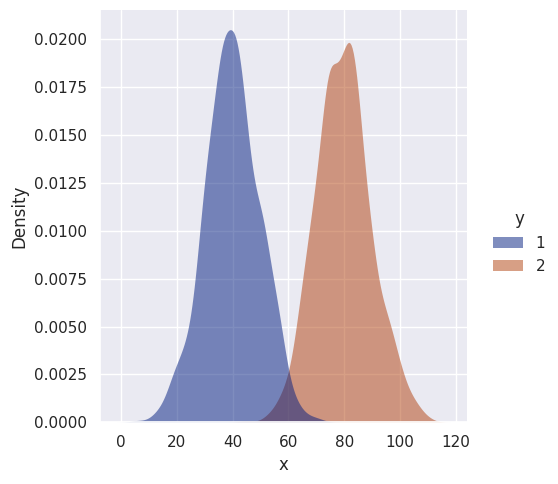

In [2]:
n = 1000
mu_1 = 40
mu_2 = 80
std = 10

x_1 = np.random.normal(loc=mu_1, scale=std, size=n)
x_2 = np.random.normal(loc=mu_2, scale=std, size=n)

df = pd.DataFrame({'x': np.concatenate([x_1, x_2]), 'y': [1] * n + [2] * n})

sns.displot(df, kind='kde', x='x', hue='y',
            fill=True, linewidth=0, palette='dark', alpha=0.5)

Time to estimate priors, means, and standard deviations. This is trivial since we generated the data but let's pretend that we didn't :)

In [3]:
priors = {k: df[df.y == k].size / df.size for k in df.y.unique()}
priors

{1: 0.5, 2: 0.5}

In [4]:
means = {k: df[df.y == k].x.mean() for k in df.y.unique()}
means

{1: 39.81007946653686, 2: 79.64703348340272}

In [5]:
stdevs = {k: df[df.y == k].x.std() for k in df.y.unique()}
# .std(ddof=0) if not sample
stdevs

{1: 9.829502308649815, 2: 9.922409640186507}

Now that the data is fit, we can build a classifier and predict new instances.

In [6]:
# note: scipy actually has gaussian pdf: from scipy.stats import norm

def uni_gaussian_pdf(x, mean, stdev):
    scalar = 1.0 / (stdev * np.sqrt(2 * np.pi))
    exponential = np.exp(-0.5 * ((x - mean) / stdev) ** 2)
    return scalar * exponential

classes = df.y.unique().tolist()

def gbayes_uni_classify(x):
    probas = []
    for c in classes:
        likelihood = uni_gaussian_pdf(x, means[c], stdevs[c])
        # likelihood = norm.pdf(x, means[c], stdevs[c])
        probas.append(likelihood * priors[c])
    return classes[np.argmax(probas)]

It's important to mention here that the priors are the same since we generated equal amounts of data for both classes.  Mathematically this means that the prior is a constant and can be factored out in the original MAP equation (for this case) giving

$$
\arg\max_y {P(X|Y)}
$$

So in the case where priors are the same, the MAP is equivalent to the MLE.

And now to visualize the decision boundary.

[59]


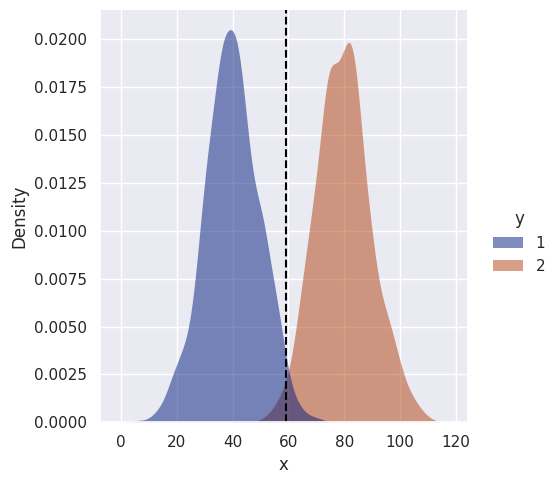

In [7]:
sim_data = np.arange(0, 150, 1)  # uniform sequence
sim_class_preds = [gbayes_uni_classify(x) for x in sim_data]

decision_boundary = np.where(np.array(sim_class_preds[:-1]) - np.array(sim_class_preds[1:]) != 0)[0]
print(decision_boundary)

sns.displot(df, kind='kde', x='x', hue='y', fill=True, linewidth=0, palette='dark', alpha=0.5)
for v in sim_data[decision_boundary]:
    plt.axvline(v, color='black', linestyle='--')

No surprises here, the decision boundary is roughly halfway between means, as expected.  Let's make things more interesting and make the variances unequal...

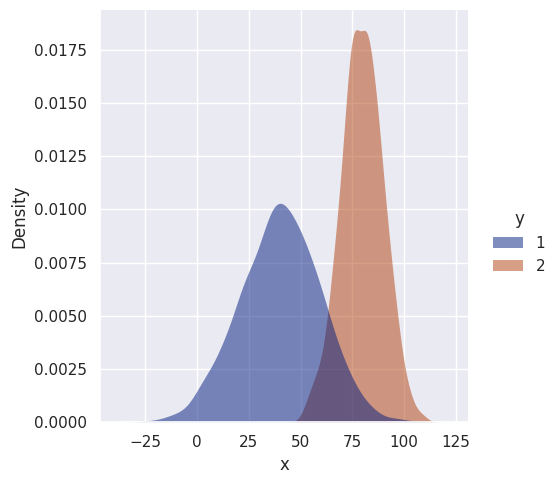

In [8]:
def gen_uni_dists_df(n1, n2, mu1, mu2, std1, std2):
    x1 = np.random.normal(loc=mu1, scale=std1, size=n1)
    x2 = np.random.normal(loc=mu2, scale=std2, size=n2)
    return pd.DataFrame({'x': np.concatenate([x1, x2]), 'y': [1] * n1 + [2] * n2})

df = gen_uni_dists_df(n1=1000, n2=1000, mu1=40, mu2=80, std1=20, std2=10)

sns.displot(df, kind='kde', x='x', hue='y', fill=True, linewidth=0, palette='dark', alpha=0.5)

In [11]:
class GBUniClf:

    def __init__(self):
        self.classes = None
        self.priors = None
        self.means = None
        self.stdevs = None

    def fit(self, df):
        self.classes = df.y.unique().tolist()
        self.priors = {k: df[df.y == k].size / df.size for k in self.classes}
        self.means = {k: df[df.y == k].x.mean() for k in self.classes}
        self.stdevs = {k: df[df.y == k].x.std() for k in self.classes}

    def likelihood(self, x, mean, stdev):
        scalar = 1.0 / (stdev * np.sqrt(2 * np.pi))
        exponential = np.exp(-0.5 * ((x - mean) / stdev) ** 2)
        return scalar * exponential

    def predict(self, x):
        probas = []
        for c in self.classes:
            likelihood = self.likelihood(x, self.means[c], self.stdevs[c])
            probas.append(likelihood * self.priors[c])
        return self.classes[np.argmax(probas)]


[113 175]


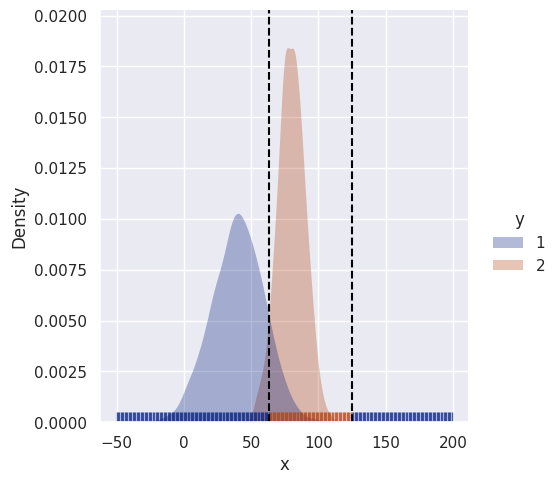

In [10]:
def uni_decision_boundary(clf, df, sim_range):

    sim_class_preds = [clf.predict(x) for x in sim_range]

    decision_boundary = np.where(np.array(sim_class_preds[:-1]) - np.array(sim_class_preds[1:]) != 0)[0]
    print(decision_boundary)

    df_preds = pd.DataFrame({'x': sim_range, 'y': sim_class_preds})

    sns.displot(df, kind='kde', x='x', hue='y', fill=True, linewidth=0, palette='dark', alpha=0.3)
    rug_plot = sns.rugplot(df_preds, x="x", hue="y", palette='dark', alpha=0.7)
    rug_plot.get_legend().remove()
    for v in sim_range[decision_boundary]:
        plt.axvline(v, color='black', linestyle='--')


clf = GBUniClf()
clf.fit(df)

sim_range = np.arange(-50, 200, 1)
uni_decision_boundary(clf, df, sim_range)

Because class 1 has a larger variance, there is now a second decision boundary.  Instances with high values of $x$ (far right) are less likely to belong to class 2 even though they are closer to its' mean.  Instead they get classified as 1.

What if the priors are different?

[120 163]


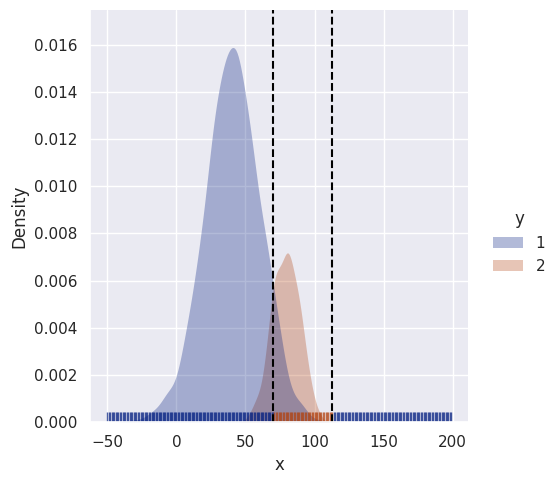

In [12]:
df = gen_uni_dists_df(n1=2000, n2=500, mu1=40, mu2=80, std1=20, std2=10)

clf = GBUniClf()
clf.fit(df)

sim_range = np.arange(-50, 200, 1)
uni_decision_boundary(clf, df, sim_range)

It simply makes the more prevalent class more likely, not unexpected.

### multivariate

Now we can look at bivariate data where covariance between features come into play.  The naive assumption ignores covariance so we can compare classifiers that do and do not make that assumption.

Mathematically, the posterior is now conditioned on multiple features

$$
P(Y|X) = P(Y|x_1, x_2, \ldots , x_i)
$$

and the MAP classifier in the multivariate case is

$$
\arg\max_y {P(Y) \cdot P(x_1, x_2, \ldots , x_i|Y)}
$$

Therefore we use the multivariate likelihood function which makes use of covariance

$$
p(x|y) = \frac{1}{\sqrt{(2\pi)^n |\Sigma_y|}} e^{ - \frac{1}{2} (x - \mu_y)^T \Sigma_y^{-1} (x - \mu_y)}
$$

This is a drop-in replacement though, and the rest of the classifier is the same.

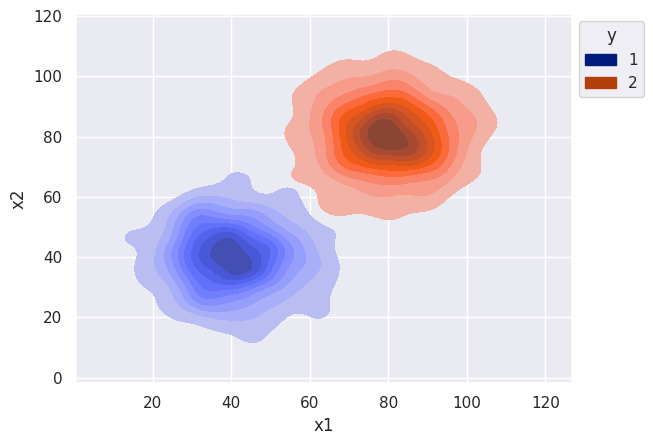

In [20]:
def gen_bi_dists_df(n1, n2, mu1, mu2, std1, std2):
    x1 = np.random.normal(loc=mu1, scale=std1, size=(n1, 2))
    x2 = np.random.normal(loc=mu2, scale=std2, size=(n2, 2))
    data = np.concatenate([x1, x2])
    return pd.DataFrame({'x1': data[:, 0], 'x2': data[:, 1], 'y': [1] * n1 + [2] * n2})

df = gen_bi_dists_df(n1=1000, n2=1000, mu1=40, mu2=80, std1=10, std2=10)

# s = sns.scatterplot(df, x='x1', y='x2', hue='y', hue_order=classes, palette='dark', alpha=0.25)
s = sns.kdeplot(df, x='x1', y="x2", hue="y", palette='dark', fill=True, alpha=1)
sns.move_legend(s, "upper left", bbox_to_anchor=(1, 1))

In [21]:
class GBBiClf:

    def __init__(self):
        self.classes = None
        self.priors = None
        self.means = None
        self.covars = None
        self.covar_dets = None
        self.covar_invs = None

    def fit(self, df):
        self.classes = df.y.unique().tolist()
        self.priors = {k: df[df.y == k].shape[0] / df.shape[0] for k in self.classes}
        self.means = {k: df[['x1', 'x2']][df.y == k].mean(axis=0) for k in self.classes}
        self.covars = {k: np.cov(df[['x1', 'x2']][df.y == k], rowvar=False, bias=True) for k in self.classes}
        self.covar_dets = {k: np.linalg.det(self.covars[k]) for k in self.classes}
        self.covar_invs = {k: np.linalg.inv(self.covars[k]) for k in self.classes}

    def likelihood(self, x, c):
        dims = 2
        scalar = 1.0 / np.sqrt(((2 * np.pi) ** dims) * self.covar_dets[c])
        exponential = np.exp(-0.5 * (x - self.means[c]).T @ self.covar_invs[c] @ (x - self.means[c]))
        return scalar * exponential

    def predict(self, x):
        probas = []
        for c in self.classes:
            likelihood = self.likelihood(x, c)
            probas.append(likelihood * self.priors[c])
        return self.classes[np.argmax(probas)]


<Axes: xlabel='x1', ylabel='x2'>

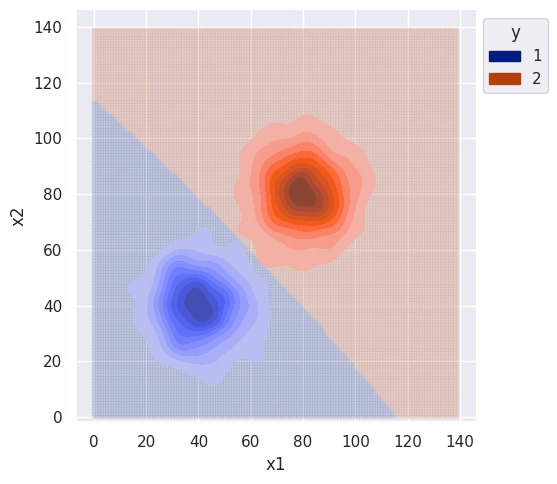

In [22]:
def bi_decision_boundary(clf, df, sim_range):

    sim_data = np.array([np.array([x1, x2]) for x1 in sim_range for x2 in sim_range])
    sim_classes = [clf.predict(x) for x in sim_data]

    plot_df = pd.DataFrame(np.hstack([sim_data, np.array(sim_classes).reshape(-1, 1)]), columns=['x1', 'x2', 'y'])

    # sns.scatterplot(plot_df, x='x1', y="x2", hue="y", hue_order=classes, palette='dark', marker=".", alpha=0.15)
    plt_points = sns.relplot(plot_df, x='x1', y='x2', hue='y', hue_order=clf.classes, palette='dark', marker=".", alpha=0.15)
    plt_points._legend.remove()
    s = sns.kdeplot(df, x='x1', y="x2", hue="y", palette='dark', fill=True, alpha=1)
    sns.move_legend(s, "upper left", bbox_to_anchor=(1, 1))
    return s


clf = GBBiClf()
clf.fit(df)

sim_range = np.arange(0, 140, 1)
bi_decision_boundary(clf, df, sim_range)

The variance was same for both distributions and the features were sampled independently, so the decision boundary isn't complex.  Slight curvature is due to the estimate of covariance which is different from the true value.

In [23]:
clf.covars

{1: array([[100.87705238,  -3.73052293],
        [ -3.73052293,  99.42549259]]),
 2: array([[106.57505726,  -3.75129152],
        [ -3.75129152, 107.04125472]])}

Even though this data is uninteresting, let's compare the decision boundary of a **naive** classifier.  The naive assumption is that all features are independent, so we can use the chain rule of probability for a simpler calculation of the likelihood.

$$
P(X|Y) = P(x_1, x_2, \ldots , x_i|Y) = \prod\limits_{i}P(x_i|Y)
$$

The MAP classifier under the naive assumption then becomes

$$
\arg\max_y {P(Y) \cdot P(x_1|Y) \cdot P(x_2|Y) \cdot \ldots \cdot P(x_m|Y)}
$$

For this case though, since the features were generated independently, the decision boundary should be roughly the same.

In [24]:
class GNBBiClf:

    def __init__(self):
        self.classes = None
        self.priors = None
        self.means = None

    def fit(self, df):
        self.classes = df.y.unique().tolist()
        self.priors = {k: df[df.y == k].shape[0] / df.shape[0] for k in self.classes}
        self.means = {k: df[['x1', 'x2']][df.y == k].mean(axis=0) for k in self.classes}
        self.stdevs = {k: np.std(df[['x1', 'x2']][df.y == k], axis=0) for k in self.classes}

    def likelihood(self, x, mean, stdev):
        scalar = 1.0 / (stdev * np.sqrt(2 * np.pi))
        exponential = np.exp(-0.5 * ((x - mean) / stdev) ** 2)
        return scalar * exponential

    def predict(self, x):
        probas = []
        for c in self.classes:
            joint_likelihood = 1
            for i, v in enumerate(x):
                likelihood = self.likelihood(v, self.means[c][i], self.stdevs[c][i])
                joint_likelihood *= likelihood
            probas.append(joint_likelihood * self.priors[c])
        return self.classes[np.argmax(probas)]


<Axes: xlabel='x1', ylabel='x2'>

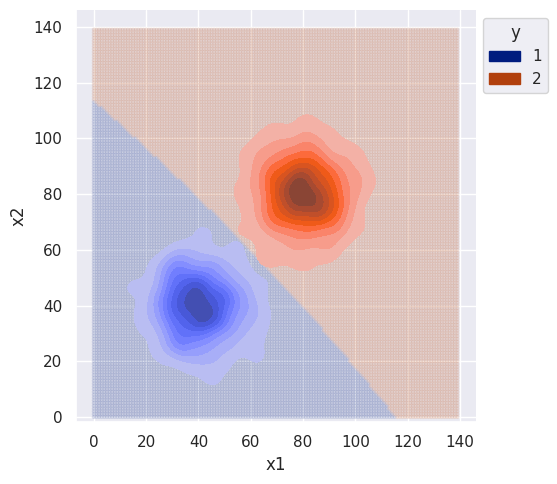

In [25]:
clf = GNBBiClf()
clf.fit(df)

sim_range = np.arange(0, 140, 1)
bi_decision_boundary(clf, df, sim_range)

What if just the covariance are different?  Let's draw random data were the features are still independent (i.e. covariance matrix is symmetic) but the variance of features is different for each class.

[(-10.0, 140.0), (-10.0, 140.0)]

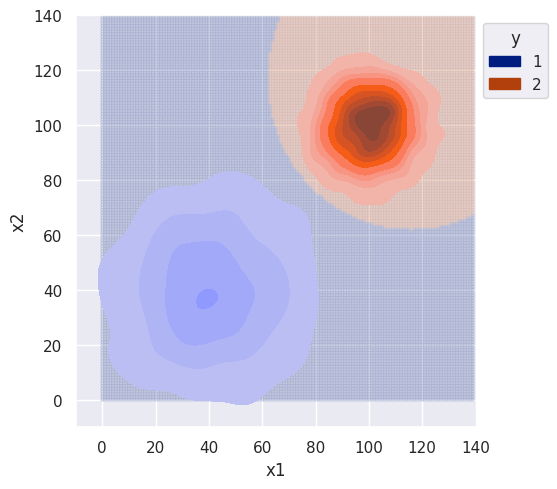

In [26]:
df = gen_bi_dists_df(n1=1000, n2=1000, mu1=40, mu2=100, std1=20, std2=10)

clf = GBBiClf()
clf.fit(df)

sim_range = np.arange(0, 140, 1)
plot = bi_decision_boundary(clf, df, sim_range)
plot.set(xlim=(-10, 140), ylim=(-10, 140))

As expected, the decision boundary favors class 1 since it had larger variance.  Without any correlation between features, I would again expect the decision boundary to be the same for the naive classifier.

[(-10.0, 200.0), (-10.0, 200.0)]

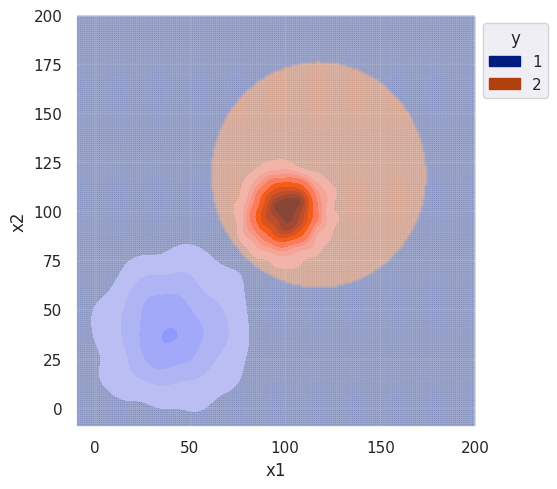

In [33]:
clf = GNBBiClf()
clf.fit(df)
# sanity check
# from sklearn.naive_bayes import GaussianNB
# clf = GaussianNB()

sim_range = np.arange(-10, 200, 1)
plot = bi_decision_boundary(clf, df, sim_range)
plot.set(xlim=(-10, 200), ylim=(-10, 200))

The decision boundary for the naive classifier is roughly identical.  Zooming out, we can see the classifier has similar behavior as the univariate case for different variance.

Let's finally simulate data with correlation between features.  There should be a noticeable difference in the decision boundary for the naive classifier.

[(-10.0, 140.0), (-10.0, 140.0)]

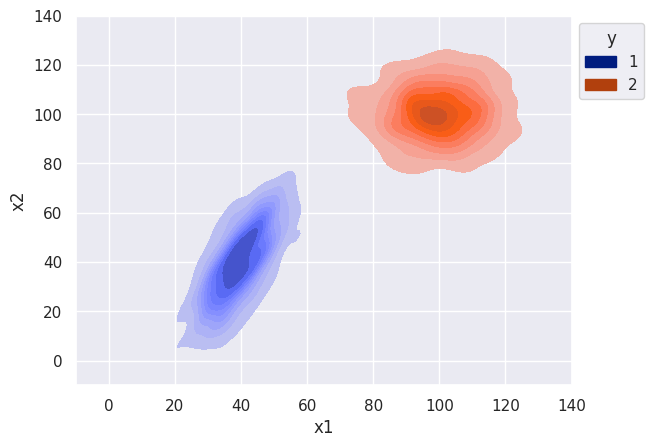

In [34]:
n = 1000
mu_1 = 40
mu_2 = 100

x_1 = np.random.multivariate_normal(mean=[mu_1, mu_1], cov=[[50, 70], [70, 200]], size=n)
x_2 = np.random.multivariate_normal(mean=[mu_2, mu_2], cov=[[100, 1], [1, 100]], size=n)  # no correlation
data = np.concatenate([x_1, x_2])

df = pd.DataFrame({'x1': data[:, 0], 'x2': data[:, 1], 'y': [1] * n + [2] * n})

s = sns.kdeplot(df, x='x1', y="x2", hue="y", palette='dark', fill=True, alpha=1)
sns.move_legend(s, "upper left", bbox_to_anchor=(1, 1))
s.set(xlim=(-10, 140), ylim=(-10, 140))

[(-10.0, 140.0), (-10.0, 140.0)]

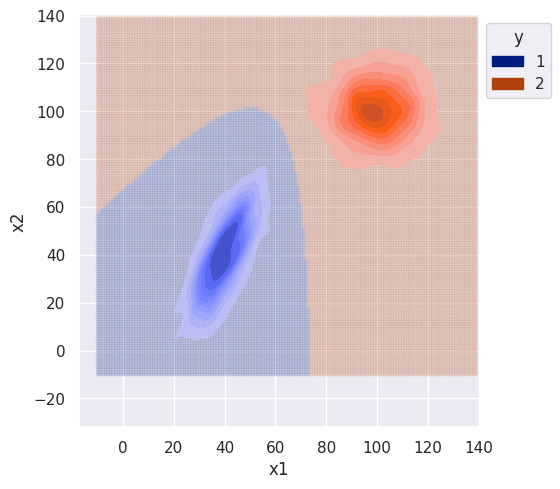

In [35]:
clf = GBBiClf()
clf.fit(df)

sim_range = np.arange(-10, 140, 1)
plot = bi_decision_boundary(clf, df, sim_range)
s.set(xlim=(-10, 140), ylim=(-10, 140))

[(-10.0, 140.0), (-10.0, 140.0)]

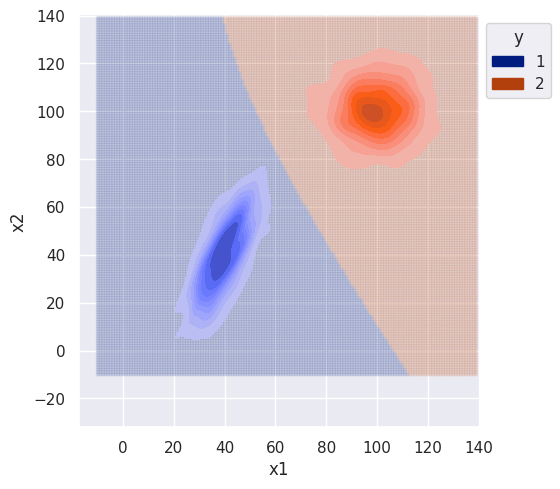

In [36]:
# naive classifier
clf = GNBBiClf()
clf.fit(df)

sim_range = np.arange(-10, 140, 1)
plot = bi_decision_boundary(clf, df, sim_range)
s.set(xlim=(-10, 140), ylim=(-10, 140))

The difference between the naive and non-naive classifier is more noticeable when there is correlation between features (class 1).  The naive classifier clearly ignores the covariance and the decision boundary is much smoother.

One obvious advantage of the naive assumption is computational efficiency.  Predictions for the naive classifier ran in faster time compared to the non-naive by an order of magnitude.  Fit times were roughly the same.

In [ ]:
from time import perf_counter

# TODO memory reqs

m = 100

start_time = perf_counter()
for i in range(m):
    clf = GBBiClf()
    clf.fit(df)
print(f"GB avg fit time: {(perf_counter() - start_time) / m:.6f}")
start_time = perf_counter()
for i in range(m):
    clf.predict(sim_data[i])
print(f"GB avg predict time: {(perf_counter() - start_time) / m:.6f}")

start_time = perf_counter()
for i in range(m):
    clf = GNBBiClf()
    clf.fit(df)
print(f"GNB avg fit time: {(perf_counter() - start_time) / m:.6f}")
start_time = perf_counter()
for i in range(m):
    clf.predict(sim_data[i])
print(f"GNB avg predict time: {(perf_counter() - start_time) / m:.6f}")

GB avg fit time: 0.004047
GB avg predict time: 0.000654
GNB avg fit time: 0.005097
GNB avg predict time: 0.000047
